In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, BatchNormalization

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
edges = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

In [ ]:
features.rename(columns = {0:'txId1'}, inplace = True)
features = pd.merge(features, edges.groupby('txId1').count(), on="txId1", how="left")
features.head()

,txId1,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,txId2
0,230425980,1,-0.056189,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133295,...,-0.582752,1.442895,1.440189,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
1,5530458,1,-0.056193,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133311,...,0.702410,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
2,232022460,1,-0.056378,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133972,...,0.467009,-1.033609,-1.032884,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,2.0
3,232438397,1,0.043005,0.743641,-0.644127,2.874647,-0.068726,2.304311,3.142835,-0.134902,...,-0.595477,0.204643,0.203652,0.994235,0.099367,-0.135784,0.669253,-0.102834,-0.102128,1.0
4,230460314,1,0.294595,-0.131268,-1.185821,0.125213,0.375512,0.188604,-0.101009,-0.134776,...,-0.380435,0.484856,0.546219,0.003514,0.312670,0.369103,1.281230,0.201809,0.202687,8.0


In [ ]:
y = classes[classes['class'] != 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
y['class']=y['class'].apply(lambda x: x=='1')
y = y.iloc[:, 1]
x_train, x_test, y_train, y_test= train_test_split(x,y)
y_train.head()

<ipython-input-12-3fde43f3ce7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class']=y['class'].apply(lambda x: x=='1')


10210     False
159360    False
74826     False
73954     False
123545    False
Name: class, dtype: bool

In [ ]:
x_train['txId2']=x_train['txId2'].apply(lambda x: np.log(1+x))
x_train.head()

,2,3,4,5,6,7,8,9,10,11,...,158,159,160,161,162,163,164,165,166,txId2
10210,-0.056232,-0.166289,0.980956,-0.131401,0.153393,-0.104662,-0.101009,-0.134835,-0.089143,-0.023801,...,5.136277,-0.335038,-0.238867,-0.106566,0.035376,0.005951,-0.077725,0.310125,-0.530308,1.098612
159360,-0.045377,-0.098521,0.980956,-0.186390,-0.046514,-0.167505,-0.101009,-0.094570,-0.067045,-0.024475,...,-0.595477,0.204643,0.203652,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,0.693147
74826,-0.056303,-0.131268,-1.185821,-0.058083,-0.046514,-0.020871,-0.101009,-0.134901,-0.088773,-0.023122,...,1.624927,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,0.693147
73954,-0.056636,-0.171625,0.439262,-0.186390,-0.046514,-0.167505,-0.101009,-0.134895,-0.089395,-0.024475,...,0.047104,-1.033609,-1.032884,-0.106566,-0.092606,-0.084494,-0.143864,1.569841,1.571490,0.000000
123545,-0.056637,-0.156841,0.980956,-0.186390,-0.068726,-0.167505,-0.101009,-0.134899,-0.089397,-0.024475,...,-0.379162,0.204643,0.203652,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,0.693147


(array([4.6556e+04, 4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  47.2,  94.4, 141.6, 188.8, 236. , 283.2, 330.4, 377.6,
        424.8, 472. ]),
 <BarContainer object of 10 artists>)

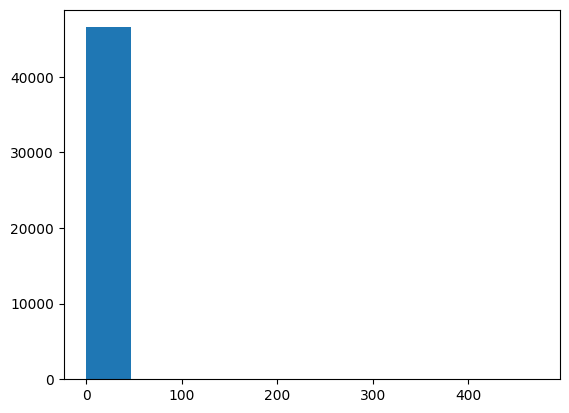

In [ ]:
plt.hist(x['txId2'])

(array([8.8680e+03, 2.4565e+04, 1.0250e+03, 3.1000e+02, 1.2600e+02,
        2.1000e+01, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.61590954, 1.23181908, 1.84772862, 2.46363816,
        3.07954769, 3.69545723, 4.31136677, 4.92727631, 5.54318585,
        6.15909539]),
 <BarContainer object of 10 artists>)

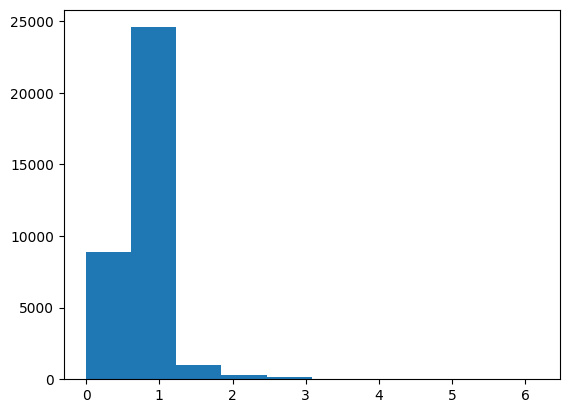

In [ ]:
plt.hist(x_train['txId2'])

In [ ]:
model = Sequential()

model.add(LSTM(64, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/5
1092/1092 [==============================] - 100s 90ms/step - loss: 0.3057 - accuracy: 0.9004 - val_loss: 0.3218 - val_accuracy: 0.8988
Epoch 2/5
1092/1092 [==============================] - 96s 88ms/step - loss: 0.2606 - accuracy: 0.9102 - val_loss: 0.2249 - val_accuracy: 0.9107
Epoch 3/5
1092/1092 [==============================] - 95s 87ms/step - loss: 0.1966 - accuracy: 0.9301 - val_loss: 0.1977 - val_accuracy: 0.9292
Epoch 4/5
1092/1092 [==============================] - 96s 88ms/step - loss: 0.1812 - accuracy: 0.9376 - val_loss: 0.2211 - val_accuracy: 0.9054
Epoch 5/5
364/364 [==============================] - 10s 27ms/step - loss: 0.3113 - accuracy: 0.8935


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

364/364 [==============================] - 10s 27ms/step - loss: 0.3113 - accuracy: 0.8935


In [ ]:
y = classes[classes['class'] == 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
x['txId2']=x['txId2'].apply(lambda x: np.log(1+x))
result=model.predict(x)

4913/4913 [==============================] - 125s 25ms/step


In [ ]:
res=np.round(result)

In [ ]:
unique, counts = np.unique(res, return_counts=True)
dict(zip(unique, counts))

{0.0: 146738, 1.0: 10467}

In [ ]:
classes_illicit = classes[classes['class'] == '1']
classes_licit = classes[classes['class'] == '2']
classes_illicit.count()/classes_licit.count()

txId     0.108165
class    0.108165
dtype: float64

In [ ]:
counts[1]/counts[0]

0.07133121618122096